In [1]:
#In this project, I wish to complete a retention analysis of a UK-based online retail buyers/users
# The data set contains all the transactions occurring between 01/12/2010 and 09/12/2011 for the company.

#Importing the packages

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import datetime as dt
%matplotlib inline

In [3]:
#Jmport the dataframe

df =pd.read_csv("online_retail.csv")

In [4]:
#Exploring the data set further to see the missing values and proportion

df.head()

df.isnull().any()

df.isnull().sum()/df.shape[0]

InvoiceNo      0.000000
StockCode      0.000000
Description    0.002683
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.249267
Country        0.000000
dtype: float64

In [5]:
# I decided to check the date format and the Description columns

df.Description.value_counts()

df['InvoiceDate']

df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [6]:
# I try to ensure that the variables match the correct data types

df['Quantity']= pd.to_numeric(df.Quantity, downcast= 'integer', errors='coerce')
df['UnitPrice']= pd.to_numeric(df.UnitPrice, downcast= 'integer', errors='coerce')
df['CustomerID']= pd.to_numeric(df.CustomerID, downcast= 'integer', errors='coerce')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [7]:
# After trying to adjust the data types, I checked the percentage of missing values after data type checks above. Only 0.2 Per cent of the Description is null, while 25 per cent of the customer ID is null. 
# CustomerID is unique record identifier, hence, I did not drop it. 

df.isnull().any()

df.CustomerID.value_counts()

df.isnull().sum()/df.shape[0]

InvoiceNo      0.000000
StockCode      0.000000
Description    0.002683
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.249267
Country        0.000000
dtype: float64

In [9]:
#Convert the InvoiceDate to an InvoiceMonth...

def getMonth(x):
    return dt.datetime(x.year, x.month,1)

df['InvoiceMonth']= df['InvoiceDate'].apply(getMonth)
df['InvoiceMonth']

0        2010-12-01
1        2010-12-01
2        2010-12-01
3        2010-12-01
4        2010-12-01
            ...    
541904   2011-12-01
541905   2011-12-01
541906   2011-12-01
541907   2011-12-01
541908   2011-12-01
Name: InvoiceMonth, Length: 541909, dtype: datetime64[ns]

In [10]:
# Done differently, as getMonth() is an in-built function that works with the datatime i.e. dt
        
df.InvoiceDate.apply(lambda x: getMonth(x))

0        2010-12-01
1        2010-12-01
2        2010-12-01
3        2010-12-01
4        2010-12-01
            ...    
541904   2011-12-01
541905   2011-12-01
541906   2011-12-01
541907   2011-12-01
541908   2011-12-01
Name: InvoiceDate, Length: 541909, dtype: datetime64[ns]

In [11]:
# Great! Now let's get the first time each customer has purchased. 

df['CohortMonth']= df.groupby('CustomerID')['InvoiceMonth'].transform('min')
df['CohortMonth']

0        2010-12-01
1        2010-12-01
2        2010-12-01
3        2010-12-01
4        2010-12-01
            ...    
541904   2011-08-01
541905   2011-08-01
541906   2011-08-01
541907   2011-08-01
541908   2011-08-01
Name: CohortMonth, Length: 541909, dtype: datetime64[ns]

In [13]:
#Next is the headers for the months a given user is active

def getDateDiff(df, column1, column2):
    year1 =  df[column1].dt.year
    month1= df[column1].dt.month
    year2 = df[column2].dt.year
    month2 =df[column2].dt.month
    year_diff = year1-year2
    month_diff = month1-month2
    return (year_diff*12 + month_diff +1)

# With these, we can derive the unique cohort intervals at which users are active

df['CohortActiveIntervals']= getDateDiff(df, 'InvoiceMonth', 'CohortMonth')
df['CohortActiveIntervals']

0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
541904    5.0
541905    5.0
541906    5.0
541907    5.0
541908    5.0
Name: CohortActiveIntervals, Length: 541909, dtype: float64

In [14]:
# Note that CohortActiveIntervals above has some duplicate elements. 
# I'd group CustomerID by CohortMonth and CohortActiveIntervals( Referring back to this for my heat map)

df['CohortMonth']= df['CohortMonth'].astype(str)

df_grouped = df.groupby(['CohortMonth', 'CohortActiveIntervals'])['CustomerID'].apply(pd.Series.nunique).reset_index()

df_grouped

,CohortMonth,CohortActiveIntervals,CustomerID
0,2010-12-01,1.0,948
1,2010-12-01,2.0,362
2,2010-12-01,3.0,317
3,2010-12-01,4.0,367
4,2010-12-01,5.0,341
...,...,...,...
86,2011-10-01,2.0,93
87,2011-10-01,3.0,46
88,2011-11-01,1.0,321
89,2011-11-01,2.0,43


In [15]:
#I decided to use pivot table so that CohortMonth is the first column, 
# the column header will be the CohortActiveIntervals and values will be counted/nunique CustomerID

df_pivoted= df_grouped.pivot_table(index='CohortMonth', columns= 'CohortActiveIntervals', values='CustomerID')

df_pivoted.head()


CohortActiveIntervals,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
CohortMonth,,,,,,,,,,,,,
2010-12-01,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
2011-01-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02-01,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03-01,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04-01,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN


In [17]:
# Great! Then I decided to convert the counts into percentages for the headmap. 
# Note that the first column(1.0 :axis=0) represents the total per cohort

# Adding together the number of customers in each cohort
Cohort_users_total = df_pivoted.iloc[:,0]
Cohort_users_total

CohortMonth
2010-12-01    948.0
2011-01-01    421.0
2011-02-01    380.0
2011-03-01    440.0
2011-04-01    299.0
2011-05-01    279.0
2011-06-01    235.0
2011-07-01    191.0
2011-08-01    167.0
2011-09-01    298.0
2011-10-01    352.0
2011-11-01    321.0
2011-12-01     41.0
Name: 1.0, dtype: float64

In [18]:
#Dividing the data_pivoted by the total number of users in each cohort

retention_rate= df_pivoted.divide(Cohort_users_total,axis=0)
retention_rate

CohortActiveIntervals,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
CohortMonth,,,,,,,,,,,,,
2010-12-01,1.0,0.381857,0.334388,0.387131,0.359705,0.396624,0.379747,0.354430,0.354430,0.394515,0.373418,0.500000,0.274262
2011-01-01,1.0,0.239905,0.282660,0.242280,0.327791,0.299287,0.261283,0.256532,0.311164,0.346793,0.368171,0.149644,NaN
2011-02-01,1.0,0.247368,0.192105,0.278947,0.268421,0.247368,0.255263,0.281579,0.257895,0.313158,0.092105,NaN,NaN
2011-03-01,1.0,0.190909,0.254545,0.218182,0.231818,0.177273,0.263636,0.238636,0.288636,0.088636,NaN,NaN,NaN
2011-04-01,1.0,0.227425,0.220736,0.210702,0.207358,0.237458,0.230769,0.260870,0.083612,NaN,NaN,NaN,NaN
2011-05-01,1.0,0.236559,0.172043,0.172043,0.215054,0.243728,0.265233,0.103943,NaN,NaN,NaN,NaN,NaN
2011-06-01,1.0,0.208511,0.187234,0.272340,0.246809,0.336170,0.102128,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,1.0,0.209424,0.204188,0.230366,0.272251,0.115183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,1.0,0.251497,0.251497,0.251497,0.137725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


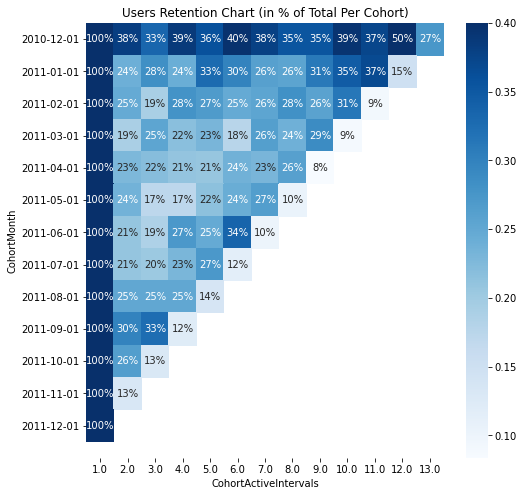

In [23]:
# Finally, I will put together this dataframe by putting it into a seaborn heatmap

plt.figure(figsize=(8, 8))

# Adding my chart title

plt.title('Users Retention Chart (in % of Total Per Cohort)')

#setting up the plot
ax = sns.heatmap(data = retention_rate, 
            #annotate the graph
            annot = True, 
            fmt = '.0%', 
            # set max value for color bar on seaborn heatmap
            vmax = 0.4,
            cmap = "Blues")

#To set the limits so we can see the entire chart

ax.set_ylim(13.5, 0)

#Yay!Let's show the plot!

plt.show()